# Cloud Segmentation Challenge

## Importing Dependencies

In [1]:
import os
import cv2
import keras
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import albumentations as albu
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras import backend as K
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate
from tensorflow import random
import segmentation_models as sm


seed = 0

Using TensorFlow backend.
/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framewo

Segmentation Models: using `keras` framework.


## Limiting GPU Memory Access

In [2]:
#To limit GPU Growth not taking up the whole memory
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

## Load and Peek into the Data

In [3]:
train = pd.read_csv('./input/train.csv')
submission = pd.read_csv('./input/sample_submission.csv')
print('Number of train samples:', train.shape[0])
print('Number of test samples:', submission.shape[0])

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
train['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
submission['image'] = submission['Image_Label'].apply(lambda x: x.split('_')[0])
test = pd.DataFrame(submission['image'].unique(), columns=['image'])

display(train.head())
display(train.describe())

Number of train samples: 22184
Number of test samples: 14792


Image_Label                                      EncodedPixels  \
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...   
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...   
2  0011165.jpg_Gravel                                                NaN   
3   0011165.jpg_Sugar                                                NaN   
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...   

         image   label  
0  0011165.jpg    Fish  
1  0011165.jpg  Flower  
2  0011165.jpg  Gravel  
3  0011165.jpg   Sugar  
4  002be4f.jpg    Fish

Image_Label                                      EncodedPixels  \
count              22184                                              11836   
unique             22184                                              11836   
top     77e9ab3.jpg_Fish  30814 1276 32214 1276 33614 1276 35014 1276 36...   
freq                   1                                                  1   

              image  label  
count         22184  22184  
unique         5546      4  
top     f19a7ed.jpg   Fish  
freq              4   5546

### Visualize Input Image (RAW)

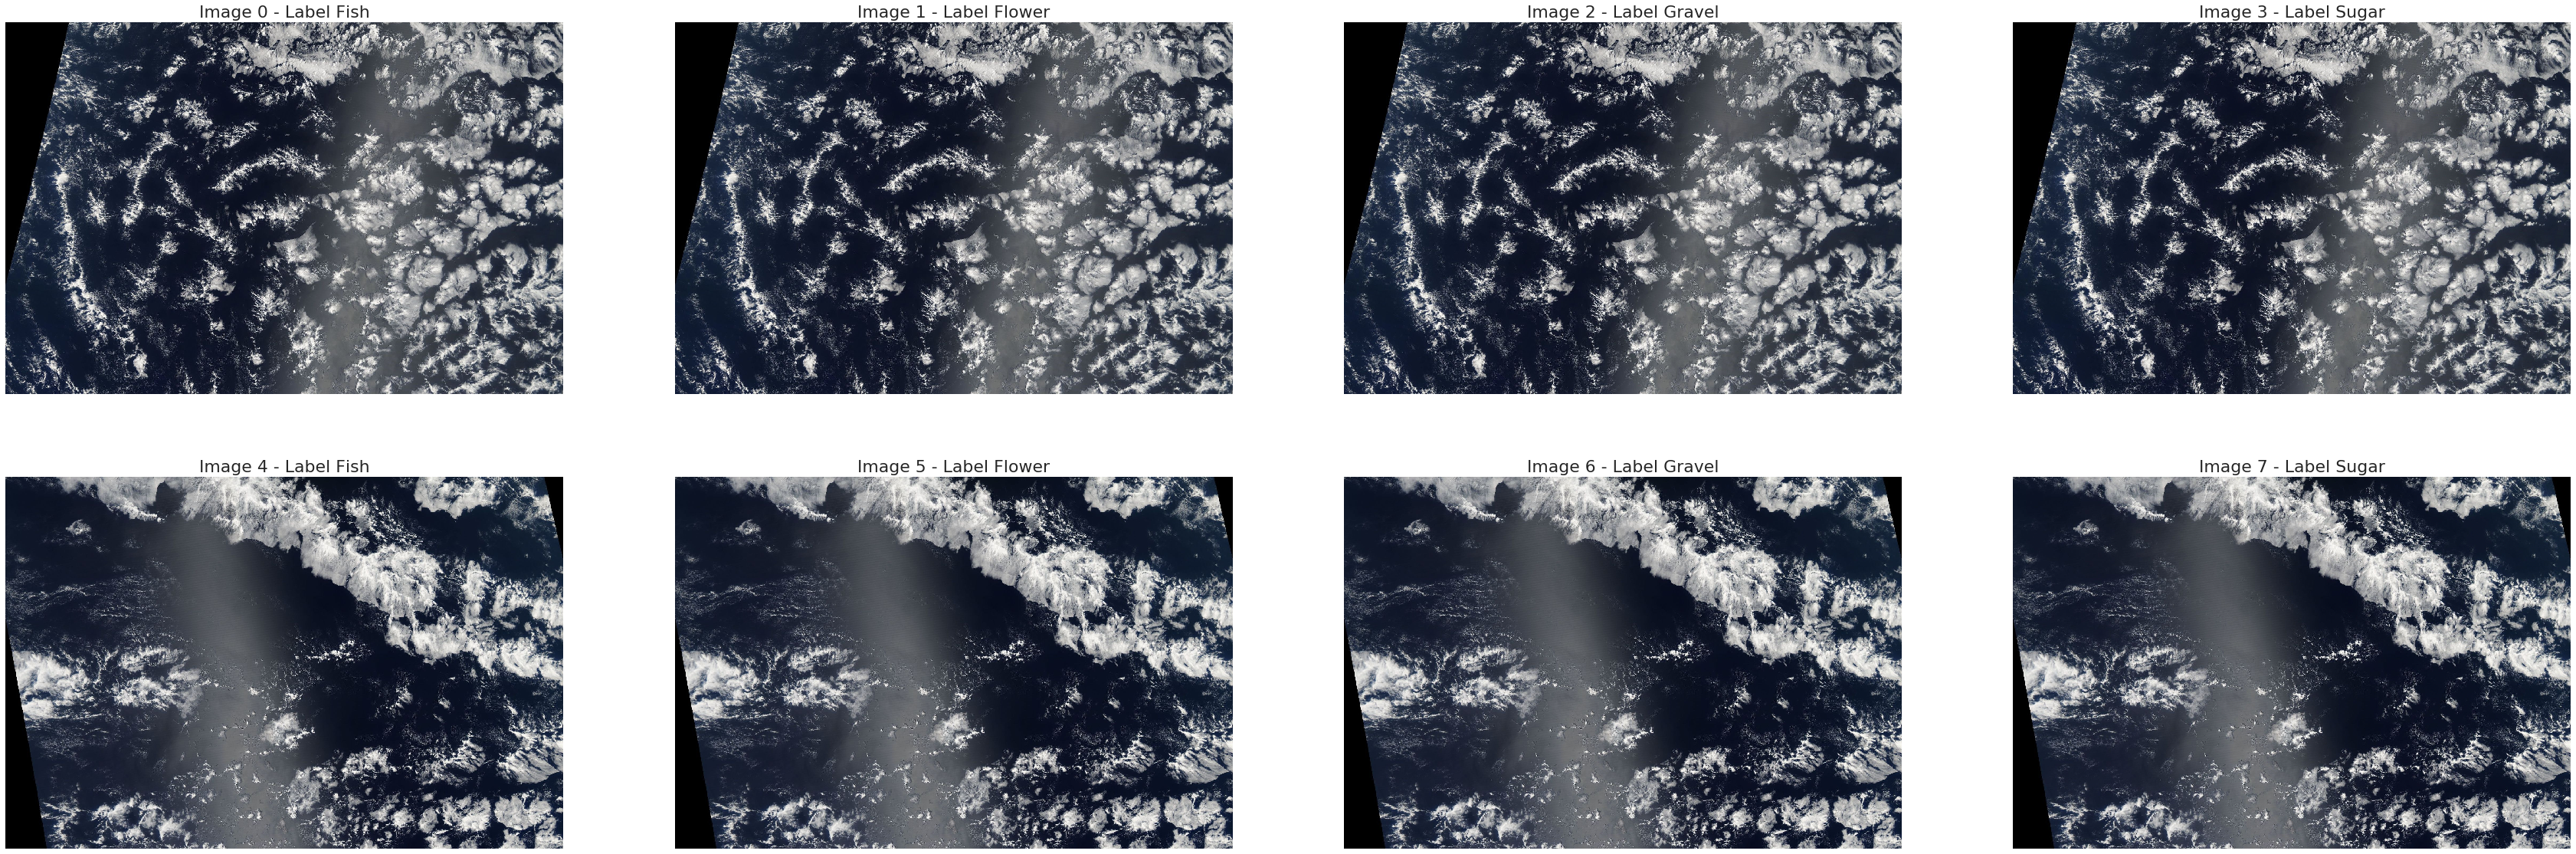

In [4]:
#Without mask
sns.set_style("white")
plt.figure(figsize=[60, 20])
for index, row in train[:8].iterrows():
    img = cv2.imread("./input/train_images/%s" % row['image'])[...,[2, 1, 0]]
    plt.subplot(2, 4, index+1)
    plt.imshow(img)
    plt.title("Image %s - Label %s" % (index, row['label']), fontsize=22)
    plt.axis('off')    
    
plt.show()

### Visualize Input Image (With Mask)

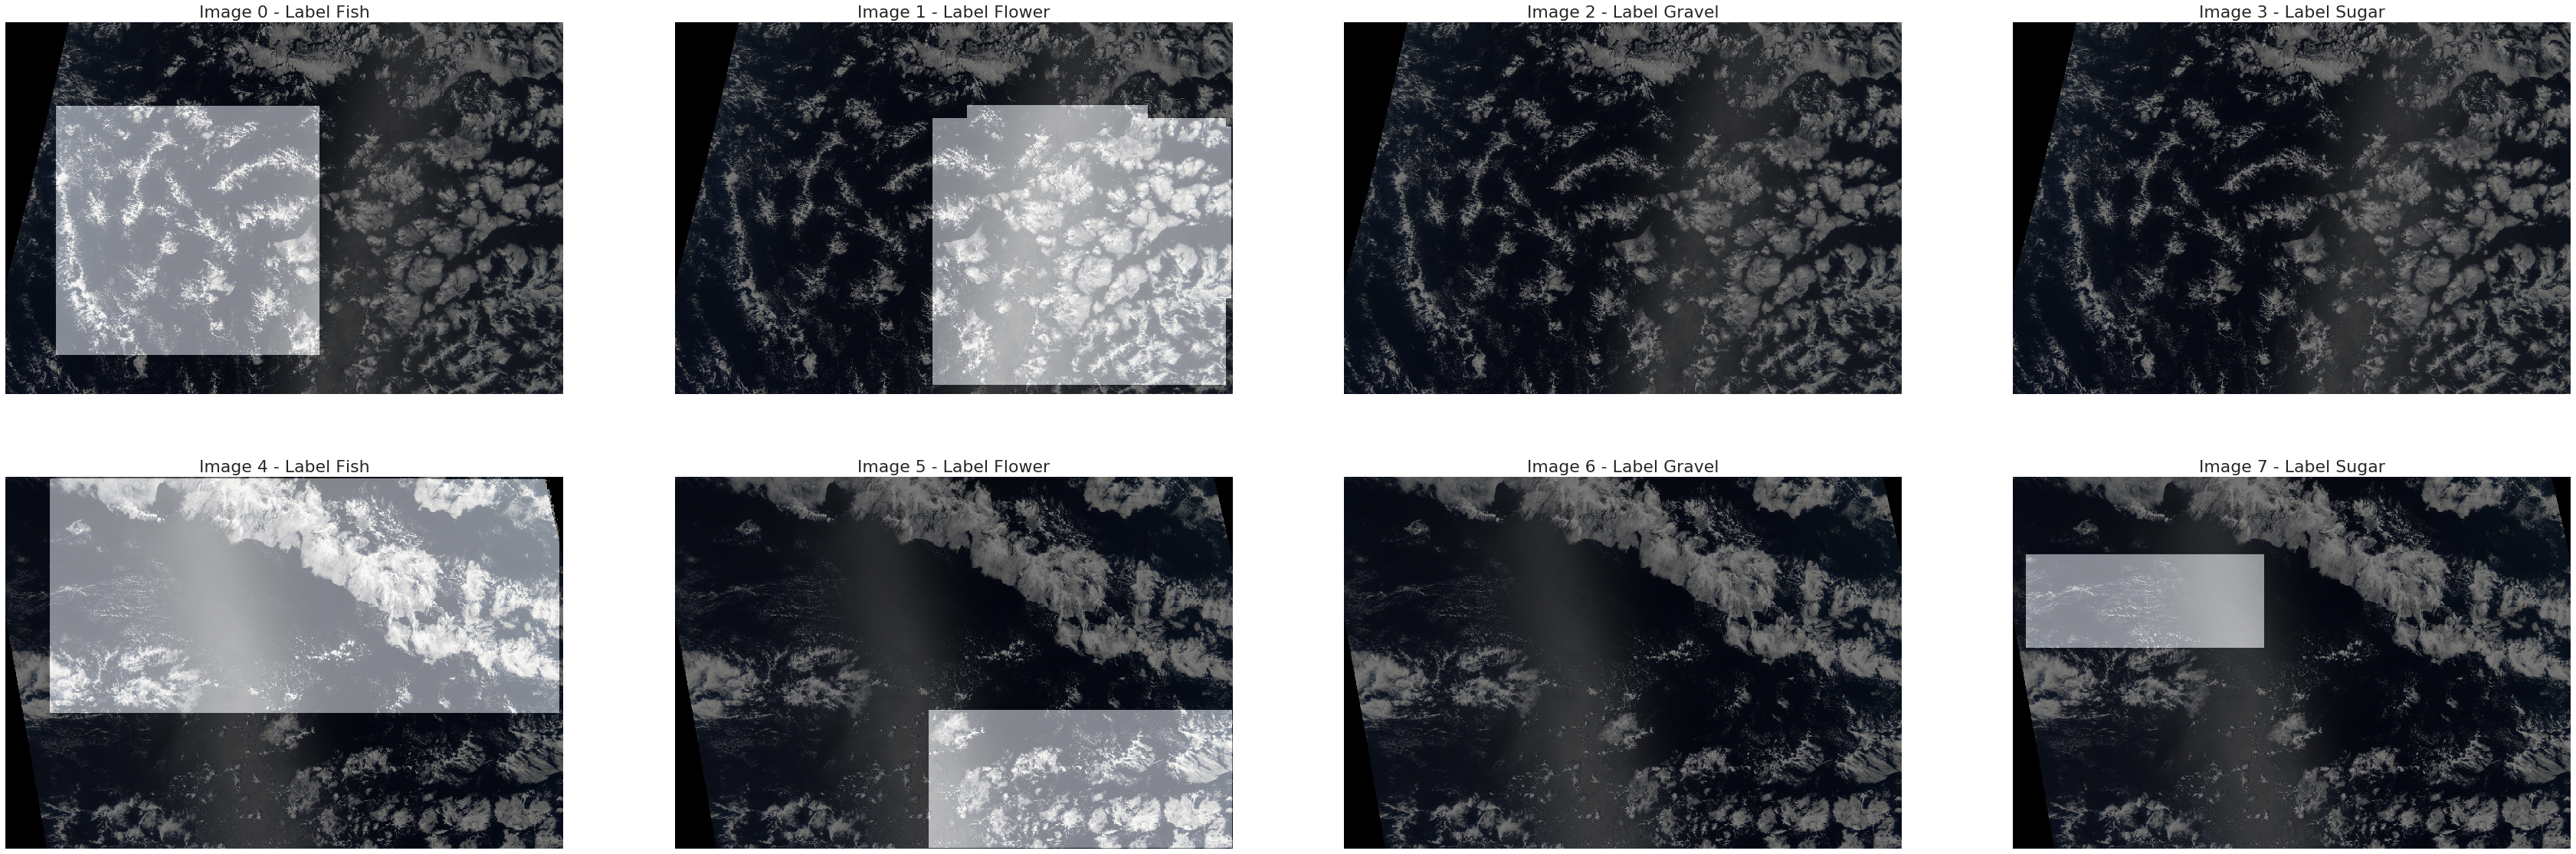

In [5]:
#With mask
def rle_decode(mask_rle, shape=(1400, 2100)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')  # Needed to align to RLE direction

plt.figure(figsize=[60, 20])
for index, row in train[:8].iterrows():
    img = cv2.imread("./input/train_images/%s" % row['image'])[...,[2, 1, 0]]
    mask_rle = row['EncodedPixels']
    try: # label might not be there!
        mask = rle_decode(mask_rle)
    except:
        mask = np.zeros((1400, 2100))
    plt.subplot(2, 4, index+1)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.5, cmap='gray')
    plt.title("Image %s - Label %s" % (index, row['label']), fontsize=22)
    plt.axis('off')    
    
plt.show()

## Split training and validation sets

In [6]:
mask_count_df = train.groupby('image').agg(np.sum).reset_index()
# mask_count_df.sort_values('Has Mask', ascending=False, inplace=True)
train_idx, val_idx = train_test_split(mask_count_df.index, test_size=0.2, random_state=seed)

## Helper Functions to Define Loss Function, Metrics, RLE Conversions

In [7]:
def np_resize(img, input_shape):
    height, width = input_shape
    return cv2.resize(img, (width, height))
    
def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask = np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
        
    return rles

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def post_process(probability, threshold=0.5, min_size=10000):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros(probability.shape, np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num


## Model parameters

In [8]:
BATCH_SIZE = 4
EPOCHS = 15
LEARNING_RATE = 3e-4
HEIGHT = 320
WIDTH = 480
CHANNELS = 3
N_CLASSES = train['label'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.05
BACKBONE = 'efficientnetb2'

## Data Generator

In [9]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='./input/train_images',
                 batch_size=BATCH_SIZE, dim=(1400, 2100), n_channels=CHANNELS, reshape=None, 
                 n_classes=N_CLASSES, random_state=seed, shuffle=True, augment=False):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.reshape = reshape
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        self.random_state = random_state
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            
            if self.augment:
                X, y = self.__augment_batch(X, y)
            
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        if self.reshape is None:
            X = np.empty((self.batch_size, *self.dim, self.n_channels))
        else:
            X = np.empty((self.batch_size, *self.reshape, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['image'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.
            
            if self.reshape is not None:
                img = np_resize(img, self.reshape)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        if self.reshape is None:
            y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        else:
            y = np.empty((self.batch_size, *self.reshape, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['image'].iloc[ID]
            image_df = self.target_df[self.target_df['image'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            
            if self.reshape is not None:
                masks = build_masks(rles, input_shape=self.dim, reshape=self.reshape)
            else:
                masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __augment_batch(self, img_batch, masks_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ], masks_batch[i, ] = self.__random_transform(img_batch[i, ], masks_batch[i, ])
        
        return img_batch, masks_batch
    
    def __random_transform(self, img, masks):
        composition = albu.Compose([albu.HorizontalFlip(p=1),
                               albu.VerticalFlip(p=1),
                               albu.GridDistortion(p=1),
                               albu.ElasticTransform(p=1),
                               albu.Rotate(limit=20)
                              ])
        
        composed = composition(image=img, mask=masks)
        aug_img = composed['image']
        aug_masks = composed['mask']
        
        return aug_img, aug_masks
    
train_generator = DataGenerator(
                  train_idx, 
                  df=mask_count_df,
                  target_df=train,
                  batch_size=BATCH_SIZE,
                  reshape=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  augment=True,
                  random_state=seed)

valid_generator = DataGenerator(
                  val_idx, 
                  df=mask_count_df,
                  target_df=train,
                  batch_size=BATCH_SIZE, 
                  reshape=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  random_state=seed)

## Defining Model (Unet & FPN)

In [10]:
# preprocess_input = sm.backbones.get_preprocessing(BACKBONE)

model = sm.FPN(
           backbone_name=BACKBONE,
           classes=N_CLASSES,
           activation='sigmoid',
           input_shape=(HEIGHT, WIDTH, CHANNELS),
           pyramid_dropout=0.8)


#es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-10, verbose=1)

metric_list = [dice_coef]
callback_list = [rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=metric_list)
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 160, 240, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 160, 240, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 160, 240, 32) 0           stem_bn[0][0]                   

block7b_dwconv (DepthwiseConv2D (None, 10, 15, 2112) 19008       block7b_expand_activation[0][0]  
__________________________________________________________________________________________________
block7b_bn (BatchNormalization) (None, 10, 15, 2112) 8448        block7b_dwconv[0][0]             
__________________________________________________________________________________________________
block7b_activation (Activation) (None, 10, 15, 2112) 0           block7b_bn[0][0]                 
__________________________________________________________________________________________________
block7b_se_squeeze (GlobalAvera (None, 2112)         0           block7b_activation[0][0]         
__________________________________________________________________________________________________
block7b_se_reshape (Reshape)    (None, 1, 1, 2112)   0           block7b_se_squeeze[0][0]         
__________________________________________________________________________________________________
block7b_se

### Start Training

In [11]:
history = model.fit_generator(generator=train_generator,
                              validation_data=valid_generator,
                              epochs=EPOCHS,
                              workers=8,
                              callbacks=callback_list,
                              verbose=1).history


Epoch 1/15
1109/1109 [==============================] - 430s 388ms/step - loss: 0.9982 - dice_coef: 0.3894 - val_loss: 1.0524 - val_dice_coef: 0.4495
Epoch 2/15
1109/1109 [==============================] - 406s 366ms/step - loss: 0.9296 - dice_coef: 0.4319 - val_loss: 0.9018 - val_dice_coef: 0.4431
Epoch 3/15
1109/1109 [==============================] - 405s 365ms/step - loss: 0.9055 - dice_coef: 0.4471 - val_loss: 0.8867 - val_dice_coef: 0.4776
Epoch 4/15
1109/1109 [==============================] - 429s 387ms/step - loss: 0.8906 - dice_coef: 0.4563 - val_loss: 0.8535 - val_dice_coef: 0.4893
Epoch 5/15
1109/1109 [==============================] - 404s 364ms/step - loss: 0.8710 - dice_coef: 0.4704 - val_loss: 1.0754 - val_dice_coef: 0.4504
Epoch 6/15
1109/1109 [==============================] - 407s 367ms/step - loss: 0.8589 - dice_coef: 0.4773 - val_loss: 0.7365 - val_dice_coef: 0.4970
Epoch 7/15
1109/1109 [==============================] - 406s 366ms/step - loss: 0.8506 - dice_coef:

## Visualizing Metrics and Loss per Epochs

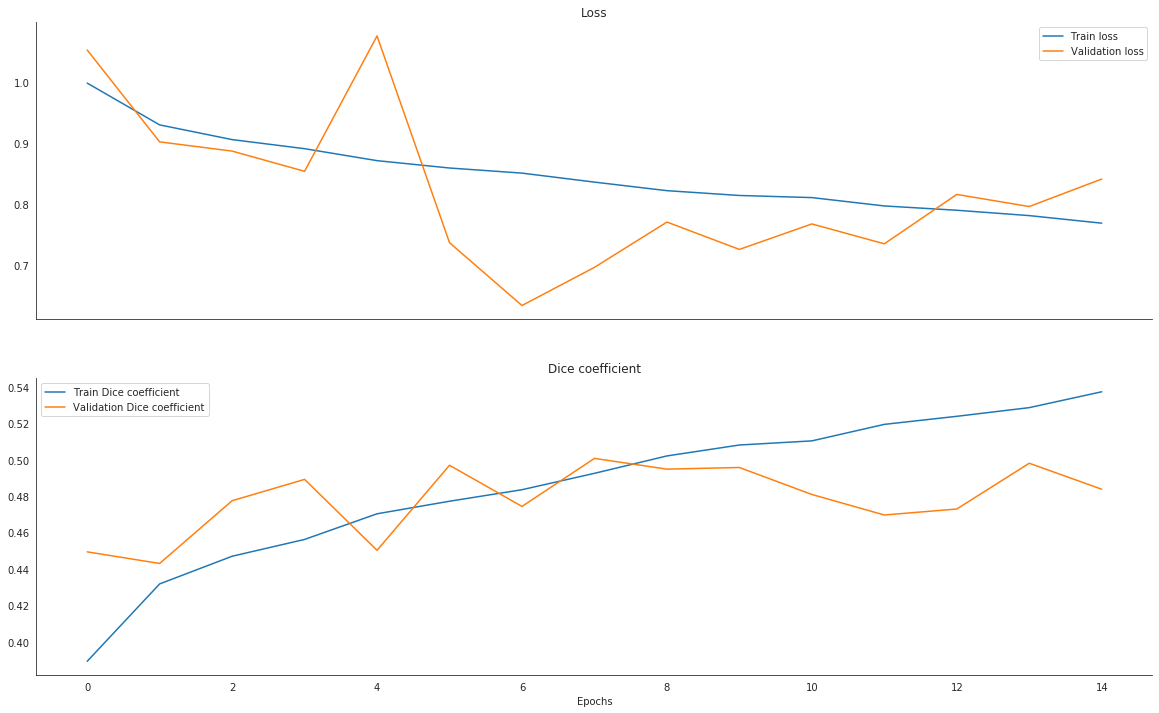

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 12))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['dice_coef'], label='Train Dice coefficient')
ax2.plot(history['val_dice_coef'], label='Validation Dice coefficient')
ax2.legend(loc='best')
ax2.set_title('Dice coefficient')

plt.xlabel('Epochs')
sns.despine()
plt.show()

## Applying Model to Test Dataset

In [13]:
test_df = []

for i in range(0, test.shape[0], 500):
    batch_idx = list(range(i, min(test.shape[0], i + 500)))
    
    test_generator = DataGenerator(
                     batch_idx,
                     df=test,
                     target_df=submission,
                     batch_size=1,
                     reshape=(HEIGHT, WIDTH),
                     dim=(350, 525),
                     n_channels=CHANNELS,
                     n_classes=N_CLASSES,
                     random_state=seed,
                     base_path='./input/test_images',
                     mode='predict',
                     shuffle=False)
    
    batch_pred_masks = model.predict_generator(test_generator)
    
    for j, b in enumerate(batch_idx):
        filename = test['image'].iloc[b]
        image_df = submission[submission['image'] == filename].copy()
        pred_masks = batch_pred_masks[j, ].round().astype(int)
        
        ### Post procecssing
        pred_masks_post = batch_pred_masks[j, ].astype('float32') 
        for k in range(pred_masks_post.shape[-1]):
            pred_mask = pred_masks_post[...,k]

            pred_mask, num_predict = post_process(pred_mask)
            pred_masks_post[...,k] = pred_mask

        pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
        image_df['EncodedPixels_post'] = pred_rles_post
        ###
        
        pred_rles = build_rles(pred_masks, reshape=(350, 525))        
        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)
        
sub_df = pd.concat(test_df)

## Submission

In [14]:
submission_df_post = sub_df[['Image_Label' ,'EncodedPixels_post']]
submission_df_post.columns = ['Image_Label' ,'EncodedPixels']
submission_df_post.to_csv('submission_post.csv', index=False)
display(submission_df_post.head())

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish                                                   
1  002f507.jpg_Flower                                                   
2  002f507.jpg_Gravel  1 55647 55651 346 56001 346 56351 345 56701 34...
3   002f507.jpg_Sugar                                                   
4    0035ae9.jpg_Fish  39275 2 39623 6 39973 7 40322 9 40670 11 41020...

##### 